Leitura dos pacotes

In [1]:
%pip install lxml
%pip install unidecode
import os
import sys
import xml.etree.ElementTree as ET
import nltk
from nltk.tokenize import RegexpTokenizer
from unidecode import unidecode
import pandas as pd
import pickle
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import csv
import pandas as pd
import logging
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import re
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from nltk.stem import PorterStemmer
from sklearn.metrics import dcg_score
from sklearn.metrics import ndcg_score

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Data Prep

Retornar para pasta raiz, assumindo execução da pasta "./src". Se não for o caso alterar para os.chdir(pasta_raiz)

In [2]:
os.chdir('..')

In [3]:
if not os.path.exists("RESULT"):
    os.makedirs("RESULT")

In [4]:
logger = logging.getLogger(__name__)

f_handler = logging.FileHandler('./RESULT/logs.log', mode='w')
f_handler.setLevel(logging.DEBUG)
logger.setLevel(logging.DEBUG)

f_format = logging.Formatter("%(levelname)s: %(message)s")
f_handler.setFormatter(f_format)

logger.addHandler(f_handler)

In [5]:
def check_error():
    with open('RESULT/logs.log', 'r') as f:
        log_content = f.read()
    if 'ERROR' in log_content:
        logger.critical("Execution interrupted. Adjust informed erros")
        f.close()
        sys.exit(1)

In [6]:
config_files = {
    "gli": {"field": ["LEIA","ESCREVA"]},
    "busca": {"field": ["MODELO", "CONSULTAS", "RESULTADOS"]},
    "pc": {"field": ["LEIA", "CONSULTAS", "ESPERADOS"]}, #read only once
    "index": {"field": ["LEIA","ESCREVA"]}  #read only once
}

In [7]:
cfg_file = "gli.cfg"
logger.info("Reading config file " + cfg_file)
gli_stemmer = False
with open(os.path.join("config_files", cfg_file), "r") as f:
    lines = f.readlines()
    if lines[0].replace(" ","").replace("\n", "") == "STEMMER":
        gli_stemmer = True
    elif lines[0].replace(" ","").replace("\n", "") =="NOSTEMMER":
        gli_stemmer = False
    else:
    # if option is not 'STEMMER' or 'NOSTEMMER', log error
        logger.error(f"Error: stemmer selection is not valid in {cfg_file}")
        
    fields = [config_files[name]['field'] for name in config_files if cfg_file.endswith(name + '.cfg')][0]
    gli_read = []
    for line in lines[1:]:
    # check if line has format "field=file_path"
        field, file_path = line.strip().split('=')
        # if field is 'LEIA', add file_path to gli_read
        if field == 'LEIA':
            gli_read.append(file_path)
            # check if file_path exists
            if not os.path.exists(file_path):
                logger.error(f"Error: {file_path} doesn't exist")
        # if field is 'ESCREVA', check that it is the last field
        elif field == 'ESCREVA':
            if field not in fields[-1]:
                logger.error(f"Error: {field} field should be the last field in {cfg_file}")
            gli_write = file_path
        # if field is not 'LEIA' or 'ESCREVA', log error

        elif field not in fields:
            logger.error(f"Error: {field} is not a valid field in {cfg_file}")
    # check that all LEIA files exist
    for leia_file in gli_read:
        if not os.path.exists(leia_file):
            print(f"Error: {leia_file} doesn't exist")
    # check that all fields are present
    if set(fields) != set(['LEIA', 'ESCREVA']):
        print(f"Error: {cfg_file} should have only 'LEIA' and 'ESCREVA' fields")
    if gli_stemmer:
        gli_write = gli_write[:-4] + "-STEMMER" + ".csv"
    else:
        gli_write = gli_write[:-4] + "-NOSTEMMER" + ".csv"

In [8]:
cfg_file = "busca.cfg"
logger.info("Reading config file " + cfg_file)

busca_model = None
busca_queries = None
busca_results = None


with open(os.path.join("config_files", cfg_file), "r") as f:
    lines = f.readlines()
    fields = [config_files[name]['field'] for name in config_files if cfg_file.endswith(name + '.cfg')][0]


    for line in lines:
        # check if line has format "field=file_path"
        field, file_path = line.strip().split('=')
        # if field is 'LEIA', add file_path to gli_read
        if field == 'MODELO':
            if busca_model != None:
                logger.error(f"Repeated field in {cfg_file}")
            busca_model = file_path
            
        # if field is 'ESCREVA', check that it is the last field
        elif field == 'CONSULTAS':
            if busca_queries != None:
                logger.error(f"Repeated field in {cfg_file}")
            busca_queries = file_path

        elif field == 'RESULTADOS':
            if busca_results != None:
                logger.error(f"Repeated field in {cfg_file}")
            busca_results = file_path

        # if field is not correct, log error
        elif field not in fields:
            logger.error(f"Error: {field} is not a valid field in {cfg_file}")
    # check that all fields are present
    if set(fields) != set(['MODELO', 'CONSULTAS','RESULTADOS']):
        logger.error(f"Error in {cfg_file} adjust fields accordingly")
    if gli_stemmer:
        busca_results = busca_results[:-4] + "-STEMMER" + ".csv"
    else:
        busca_results = busca_results[:-4] + "-NOSTEMMER" + ".csv"

In [9]:
cfg_file = "index.cfg"
logger.info("Reading config file " + cfg_file)

index_read = None
index_write = None

with open(os.path.join("config_files", cfg_file), "r") as f:
    lines = f.readlines()
    fields = [config_files[name]['field'] for name in config_files if cfg_file.endswith(name + '.cfg')][0]
    for line in lines:    
    # check if line has format "field=file_path"
        field, file_path = line.strip().split('=')
        
        if field == 'LEIA':
            if index_read != None:
                logger.error(f"Repeated field in {cfg_file}")
            index_read = file_path
        
        elif field == 'ESCREVA':
            # if field is 'ESCREVA', check that it is the last field
            if field not in fields[-1]:
                logger.error(f"Error: {field} field should be the last field in {cfg_file}")
            if index_write != None:
                logger.error(f"Repeated field in {cfg_file}")
            index_write = file_path
        # if field is not 'LEIA' or 'ESCREVA', print error
        elif field not in fields:
            logger.error(f"Error: {field} is not a valid field in {cfg_file}")
    # check that all LEIA files exist
    for leia_file in gli_read:
        if not os.path.exists(leia_file):
            logger.error(f"Error: {leia_file} doesn't exist")
    # check that all fields are present
    if set(fields) != set(['LEIA', 'ESCREVA']):
        logger.error(f"Error: {cfg_file} should have only 'LEIA' and 'ESCREVA' fields")
    if gli_stemmer:
        index_read = index_read[:-4] + "-STEMMER" + ".csv"
    else:
        index_read = index_read[:-4] + "-NOSTEMMER" + ".csv"

In [10]:
cfg_file = "pc.cfg"
logger.info("Reading config file " + cfg_file)

pc_read = None
pc_queries = None
pc_expected = None
pc_stemmer = False

with open(os.path.join("config_files", cfg_file), "r") as f:
    lines = f.readlines()

    if lines[0].replace(" ","").replace("\n", "") == "STEMMER":
        pc_stemmer = True
    elif lines[0].replace(" ","").replace("\n", "") == "NOSTEMMER":
        pc_stemmer = False
    else:
    # if option is not 'STEMMER' or 'NOSTEMMER', log error
        logger.error(f"Error: stemmer selection is not valid in {cfg_file}")

    fields = [config_files[name]['field'] for name in config_files if cfg_file.endswith(name + '.cfg')][0]
    for line in lines[1:]:
        # check if line has format "field=file_path"
        field, file_path = line.strip().split('=')
        # if field is 'LEIA', add file_path to gli_read
        if field == 'LEIA':
            if pc_read != None:
                logger.error(f"Repeated field in {cfg_file}")
            pc_read = file_path
            
        # if field is 'ESCREVA', check that it is the last field
        elif field == 'CONSULTAS':
            if pc_queries != None:
                logger.error(f"Repeated field in {cfg_file}")
            pc_queries = file_path

        elif field == 'ESPERADOS':
            if pc_expected != None:
                logger.error(f"Repeated field in {cfg_file}")
            pc_expected = file_path

        # if field is not correct, print error
        elif field not in fields:
            logger.error(f"Error: {field} is not a valid field in {cfg_file}")
    # check that all fields are present
    if set(fields) != set(['LEIA', 'CONSULTAS','ESPERADOS']):
        logger.error(f"Error: {cfg_file} adjust fields accordingly")


In [11]:
check_error()

In [12]:
print(f"Generate inverse list read file(s): {gli_read}")
print(f"Generate inverse list write file: {gli_write}")
print(f"Searcher model: {busca_model}")
print(f"Searcher queries: {busca_queries}")
print(f"Searcher results: {busca_results}")
print(f"Query processor read file: {pc_read}")
print(f"Query processor query file: {pc_queries}")
print(f"Query processor expected file: {pc_expected}")
print(f"Index read file: {index_read}")
print(f"Index write file: {index_write}")

Generate inverse list read file(s): ['CysticFibrosis2-20230331/data/cf74.xml', 'CysticFibrosis2-20230331/data/cf75.xml', 'CysticFibrosis2-20230331/data/cf76.xml', 'CysticFibrosis2-20230331/data/cf77.xml', 'CysticFibrosis2-20230331/data/cf78.xml', 'CysticFibrosis2-20230331/data/cf79.xml']
Generate inverse list write file: RESULT/LISTA INVERSA-NOSTEMMER.csv
Searcher model: RESULT/ModeloTFIDF.pkl
Searcher queries: RESULT/CONSULTAS.csv
Searcher results: RESULT/RESULTADOS-NOSTEMMER.csv
Query processor read file: CysticFibrosis2-20230331/data/cfquery.xml
Query processor query file: RESULT/CONSULTAS.csv
Query processor expected file: RESULT/ESPERADOS.csv
Index read file: RESULT/LISTA INVERSA-NOSTEMMER.csv
Index write file: RESULT/ModeloTFIDF.pkl


In [13]:
paths = gli_read + [gli_write] + [busca_model] + [busca_queries] + [busca_results] + [pc_read] + [pc_queries] + [pc_expected] + [index_read] + [index_write]
for file_path in paths:
    dir_path = os.path.dirname(file_path)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

Module 1 - Query Processor

In [14]:
logger.info("Module 1: Query processor started")
def process_query_text(query):
    words = word_tokenize(query)

    # Join the words back into a single string
    processed_query = " ".join(words)
    # Convert the processed query to uppercase
    processed_query = processed_query.upper()
    if pc_stemmer:
        stemmer = PorterStemmer()
        text = query.upper()
        tokenizer = RegexpTokenizer(r'[a-zA-Z]+') 
        words_list = tokenizer.tokenize(unidecode(text))
        words_list = [stemmer.stem(word) for word in words_list]
        processed_query = " ".join(words)
    return processed_query

In [15]:
def read_queries():
    query_file = pc_read
    logger.info("Reading file " + query_file)

    
    tree = ET.parse(query_file)
    root = tree.getroot()

    queries = {}

    for query in root.iter("QUERY"):
        query_number = int(query.find("QueryNumber").text)
        query_text = re.sub('\s+', ' ',query.find("QueryText").text.strip().replace(";", " "))
        num_results = int(query.find("Results").text)

        query_text = process_query_text(query_text)

        queries[query_number] = {
            "query_text": query_text,
            "num_results": num_results
        }

        expected_results = {}

        for item in query.iter("Item"):
            expected_result = int(item.text)
            expected_score = 0

            for value in item.get("score"):
                expected_score += int(value)

            expected_results[expected_result] = expected_score
            expected_results
        queries[query_number]["expected_results"] = expected_results
    return queries

In [16]:
def write_queries(queries):
    query_data_list = []
    
    for query_number, query_data in queries.items():
        expected_results = query_data["expected_results"]

        expected_results_str = ";".join([f"{doc_num}:{doc_votes}" for doc_num, doc_votes in expected_results.items()])
        query_data_list.append({"QueryNumber": query_number, "QueryText": query_data["query_text"], "NumResults": query_data["num_results"], "ExpectedResults": expected_results_str})

    queries_df = pd.DataFrame(query_data_list, columns=["QueryNumber", "QueryText"])

    processed_queries_file = pc_queries
    queries_df.to_csv(processed_queries_file, index=False, sep=";")
    logger.info("%d queries read and written to %s." % (queries_df.shape[0], processed_queries_file))


In [17]:
def write_expected(queries):
    logger.info("Writing expected results.")
    if len(queries.keys()) == 0:
        logger.error("Method 'read_and_write_queries' must be executed first.")
        return

    expected_results_list = []

    for query_number in sorted(queries.keys()):
        expected_results = queries[query_number]["expected_results"]
        for document_number in sorted(expected_results, key = expected_results.get, reverse = True):
            expected_results_list.append({"QueryNumber": query_number, "DocNumber": document_number, "DocVotes": str(expected_results[document_number])})
    
    expected_results_df = pd.DataFrame(expected_results_list, columns=["QueryNumber", "DocNumber","DocVotes"])

    expected_results_file = pc_expected
    expected_results_df.to_csv(expected_results_file, index=False, sep=";")
    logger.info("%d expected results written to '%s'." % (expected_results_df.shape[0], expected_results_file))

In [18]:
def pc_module_run():
    queries = read_queries()
    write_queries(queries)
    write_expected(queries)


Run Module 1

In [19]:
pc_module_run()
logger.info("Module 1: Query processor finished")

Module 2 - Invert List Generator

In [20]:
logger.info("Module 2: Inverted List Generator started")

def read_input_files():
    input_documents = {}

    for path in gli_read:
        logger.info("Reading file " + path)

        tree = ET.parse(path)
        root = tree.getroot()

        for document in root.iter("RECORD"):
            doc_identifier = document.find("RECORDNUM")
            doc_text = document.find("ABSTRACT")

            if doc_identifier is not None:
                doc_identifier = int(doc_identifier.text.strip())
            else:
                logger.warning("RECORDNUM not found for a doc in  %s" %path)
                continue
            if doc_text is None:
                doc_text = document.find("EXTRACT")

                if doc_text is None:
                    logger.warning("Document %d in %s without ABSTRACT and EXTRACT." %(doc_identifier, path))
                    continue

            doc_text = doc_text.text.strip()

            # logs reading document

            input_documents[doc_identifier] = doc_text

    return input_documents

In [21]:
def generate_inverted_list(input_documents, stemmer = False):
    inverted_list = {}

    if stemmer:
        gli_stemmer = PorterStemmer()
        
    for document_id in sorted(input_documents.keys()):
        text = input_documents[document_id].upper()
        tokenizer = RegexpTokenizer(r'[a-zA-Z]+') 
        words_list = tokenizer.tokenize(unidecode(text))

        if stemmer:
            words_list = [gli_stemmer.stem(word) for word in words_list]

        for word in words_list:
            if word not in inverted_list:
                inverted_list[word] = []

            inverted_list[word].append(document_id)

    logger.info("Inverted list generated with %d terms considered." %len(inverted_list))

    return inverted_list

In [22]:
def save_inverted_list(gli_write, inverted_list):

    inverted_df = pd.DataFrame({"term": sorted(inverted_list.keys()), "indexes": [sorted(inverted_list[term]) for term in sorted(inverted_list.keys())]})
    inverted_df["indexes"] = inverted_df["indexes"].apply(lambda x: "[" + ",".join(str(num) for num in x) + "]")
    inverted_df.to_csv(gli_write, sep=";", index=False,header = False)

    total_terms = inverted_df.shape[0]
    logger.info("%d terms written. Saved inverted list to '%s'" % (total_terms, gli_write))

In [23]:
def gli_module_run():
    input_documents = read_input_files()
    inverted_list = generate_inverted_list(input_documents)
    save_inverted_list(gli_write, inverted_list)

Run Module 2

In [24]:
gli_module_run()
logger.info("Module 2: Generate Inverted List finished")

Module 3 - Indexer

In [25]:
logger.info("Module 3: Index started")

def read_docs_dict(index_read, min_length_word=2):
    docs_dict = {}

    with open(index_read, 'r') as f:
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            word = row[0]
            if len(word) >= min_length_word:
                docs = [int(doc) for doc in row[1][1:-1].split(',')]
                docs_dict[word] = docs
    logger.info("Loading word and documents data from %s" %index_read)

    return docs_dict

In [26]:
def get_tfidf_model(docs_dict):
    docs = []
    for doc_index in set([doc for docs in docs_dict.values() for doc in docs]):
        doc = ' '.join([word for word, docs in docs_dict.items() if doc_index in docs])
        docs.append(doc)

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(docs)

    logger.info("tfidf matrix created.")
    return tfidf_matrix, vectorizer
    
#dense_matrix = tfidf_matrix.toarray()

In [27]:
def save_model(tfidf_matrix, vectorizer, index_write):
    with open(index_write, 'wb') as f:
        pickle.dump((tfidf_matrix, vectorizer), f)
    logger.info("tfidf matrix and vectorizer saved to %s."%index_write)

In [28]:
def index_module_run():
    docs_dict = read_docs_dict(index_read)
    tfidf_matrix, vectorizer = get_tfidf_model(docs_dict)
    save_model(tfidf_matrix, vectorizer, index_write)

Run Module 3

In [29]:
index_module_run()
logger.info("Module 3: Index finished.")

Module 4 - Searcher

In [30]:
logger.info("Module 4: Searcher started")
def load_tfidf_matrix():
    # Load the tf-idf matrix from a pickle file
    with open(busca_model, 'rb') as f:
        tfidf_matrix, vectorizer = pickle.load(f)
        logger.info("tfidf model loaded from %s" %busca_model)
        return tfidf_matrix, vectorizer

In [31]:
def load_queries(busca_queries, stemmer = False):
    queries_df = pd.read_csv(busca_queries, delimiter=';', quotechar='"')
    queries = dict(zip(queries_df['QueryNumber'], queries_df['QueryText']))
    logger.info("Queries loaded from %s" %busca_queries)
    return queries


In [32]:
def calculate_similarity(tfidf_matrix, vectorizer, queries):
    query_matrix = vectorizer.transform(queries.values())
    query_matrix = TfidfVectorizer(vocabulary=vectorizer.vocabulary_).fit_transform(queries.values()) 
    query_matrix_binary = query_matrix.sign() #.sign() is used so weight is 1 for all words in query and 0 if word not in query

    similarity_matrix = cosine_similarity(tfidf_matrix, query_matrix_binary)
    results = []

    for query_number, query_text in queries.items():
        similarity_scores = similarity_matrix[:, list(queries.keys()).index(query_number)]
        sorted_indices = np.argsort(similarity_scores)[::-1]

        for rank, index in enumerate(sorted_indices):
            document_number = index + 1
            similarity_distance = similarity_scores[index]
            results.append([query_number, [rank+1, document_number, similarity_distance]])

    return results

In [33]:
def write_results(busca_results, results):
    with open(busca_results, 'w', newline='') as f:
        writer = csv.writer(f, delimiter=';')
        writer.writerows(results)
    logger.info("Results saved to %s" %busca_results)

In [34]:
def busca_module_run():
    tfidf_matrix, vectorizer = load_tfidf_matrix() 
    queries = load_queries(busca_queries)
    results = calculate_similarity(tfidf_matrix, vectorizer, queries)
    write_results(busca_results, results)

Run Module 4

In [35]:
busca_module_run()
logger.info("Module 4: Searcher finished")
logger.info("Execution completed")

Module 5: Evaluation

In [36]:
if not os.path.exists("AVALIA"):
    os.makedirs("AVALIA")

if gli_stemmer == True:
    stemmer = True
else:
    stemmer = False
    
if stemmer:
    report_file = "RELATORIO-STEMMER.md"
    r_precision_histogram_filename = "R_Precision_histogram-STEMMER.png"
    eleven_point_plot_curve_filename = "11_point_curve-STEMMER.png"
else:
    report_file = "RELATORIO-NOSTEMMER.md"
    r_precision_histogram_filename = "R_Precision_histogram-NOSTEMMER.png"
    eleven_point_plot_curve_filename = "11_point_curve-NOSTEMMER.png"

In [37]:
expected_df = pd.read_csv(pc_expected, sep=';')
results_df = pd.read_csv(busca_results, sep=';', header = None, names = ['QueryNumber', 'Column2'])

In [38]:
# Split the second column into separate columns with column names
new_columns = results_df['Column2'].str.strip("[]").str.split(",", expand=True)
new_columns.columns = ['Rank', 'DocNumber', 'cosine_distance_metric']

# Join the new columns to the original DataFrame
results_df = results_df.drop(columns=['Column2']).join(new_columns)

results_df['Rank'] = results_df['Rank'].astype('int64')
results_df['DocNumber'] = results_df['DocNumber'].astype('int64')
results_df['cosine_distance_metric'] = results_df['cosine_distance_metric'].astype('float')

In [39]:
# Perform a left join on results_df and expected_df
merged_df = results_df.merge(expected_df, on=['QueryNumber', 'DocNumber'], how='left')

# Sort the merged_df by Rank in ascending order
sorted_df = merged_df.sort_values(by=['QueryNumber','Rank'])

threshold = 0  # Adjust the threshold as needed
# Convert DocVotes to binary classification labels
sorted_df['labels'] = np.where(sorted_df['DocVotes'] > threshold, 1, 0)
sorted_df


,QueryNumber,Rank,DocNumber,cosine_distance_metric,DocVotes,labels
0,1,1,559,0.174312,NaN,0
1,1,2,431,0.172057,NaN,0
2,1,3,842,0.158598,NaN,0
3,1,4,297,0.155476,NaN,0
4,1,5,1139,0.151579,NaN,0
...,...,...,...,...,...,...
120280,100,1211,298,0.023358,NaN,0
120281,100,1212,356,0.021826,NaN,0
120282,100,1213,462,0.021676,NaN,0
120283,100,1214,549,0.019425,NaN,0


11-points precision recall curve

In [40]:
def eleven_points_precision_recall_curve(): # Initialize an empty list to store the precision and recall values for each query
    precision_values = []
    recall_values = []

    # Loop through each unique query number
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter the DataFrame for the current query number
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]
        
        # Get the relevant documents for the current query
        relevant_documents = query_df[query_df['labels'] == 1]
        total_relevant_documents = len(relevant_documents)
        
        # Calculate precision and recall at fixed intervals
        precision = []
        recall = []
        
        number_of_points = 11
        incremental_results_index = int(len(query_df) / number_of_points)
        
        for i in range(number_of_points):
            results_ranking = query_df.iloc[:((i + 1) * incremental_results_index)]
            true_positives = len(results_ranking[results_ranking['labels'] == 1])
            
            precision.append(true_positives / len(results_ranking))
            recall.append(true_positives / total_relevant_documents)
        
        # Append precision and recall values to the overall lists
        precision_values.append(precision)
        recall_values.append(recall)

    # Compute the mean precision and mean recall across all queries
    mean_precisions = np.mean(precision_values, axis=0)
    mean_recalls = np.mean(recall_values, axis=0)

    # Plot the mean precision vs. mean recall scatter plot
    plt.scatter(mean_recalls, mean_precisions)
    plt.title("Mean Precision x Mean Recall")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.savefig(os.path.join("AVALIA", "11_point_curve.png"))
    plt.show()
    return os.path.join("AVALIA", "11_point_curve.png")

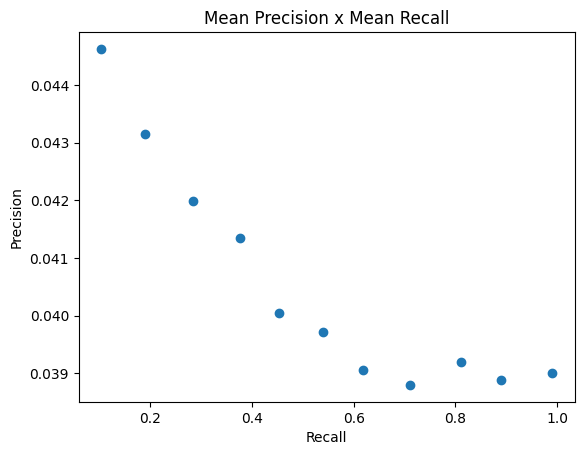

'AVALIA\\11_point_curve.png'

In [41]:
eleven_points_precision_recall_curve()

F1 score

In [42]:
def f1():

    # Initialize lists to store true positives, false positives, and false negatives for each query
    true_positives = []
    false_positives = []
    false_negatives = []

    # Loop through each unique query number
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter the DataFrame for the current query number
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]
        
        # Get the relevant documents for the current query
        relevant_documents = query_df[query_df['labels'] == 1]
        
        # Count true positives, false positives, and false negatives
        tp = len(relevant_documents)
        fp = np.sum(query_df['labels'] == 0)
        fn = 0 if tp > 0 else 1
        
        # Append the counts to the overall lists
        true_positives.append(tp)
        false_positives.append(fp)
        false_negatives.append(fn)

    # Calculate precision, recall, and F1 score for each query
    precisions = np.divide(true_positives, np.add(true_positives, false_positives))
    recalls = np.divide(true_positives, np.add(true_positives, false_negatives))
    f1_scores = np.divide(2 * np.multiply(precisions, recalls), np.add(precisions, recalls))

    # Compute the average precision, recall, and F1 score across all queries
    avg_f1 = np.mean(f1_scores)

    return avg_f1


In [43]:
f1()

0.0724696466960625

Precision@5 and Precision@10

In [44]:
def precision_at_k(k):

    # Initialize variables to store precision@5 and precision@10 values
    precision_at_k = []

    # Loop through each unique query number
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter the DataFrame for the current query number
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]
        
        # Get the labels and ranks for the current query
        labels = query_df['labels']
        ranks = query_df['Rank']
        
        # Calculate precision@k
        precisionk = np.mean(labels[ranks <= k])
        
        # Append the precision values to the overall lists
        precision_at_k.append(precisionk)

    # Compute the average precision@5 and precision@10 across all queries
    avg_precision_at_k = np.mean(precision_at_k)

    # Print the average precision@5 and precision@10
    return avg_precision_at_k

In [45]:
precision_at_k(5)

0.06666666666666667

In [46]:
precision_at_k(10)

0.06262626262626261

R-Precision Histogram

In [47]:
def r_precision_histogram(path, filename):

    # Initialize lists to store query numbers and R precision values
    query_numbers = []
    r_precision_values = []

    # Loop through each unique query number
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter the DataFrame for the current query number
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]
        
        # Get the labels and calculate R precision
        labels = query_df['labels']
        r_precision = np.mean(labels[:len(labels)])
        
        # Append the query number and R precision value to the lists
        query_numbers.append(query_number)
        r_precision_values.append(r_precision)

    # Plot the R precision values
    plt.bar(query_numbers, r_precision_values, color='b')
    plt.xlabel('Query Number')
    plt.ylabel('R Precision')
    plt.title('R Precision for Each Query')
    plt.grid(True)
    plt.savefig(os.path.join(path, filename))
    plt.show()
    

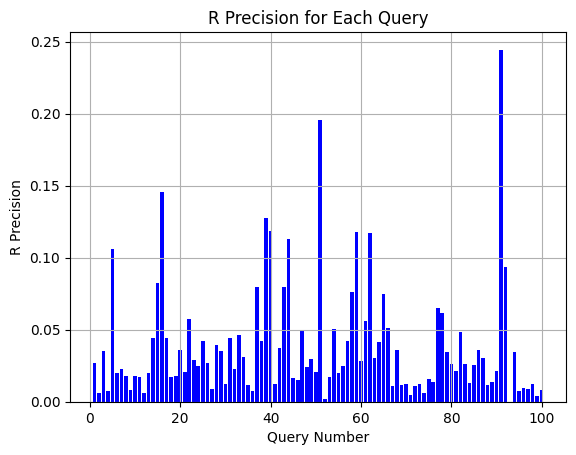

In [48]:
r_precision_histogram("AVALIA", "R_Precision_histogram.png")

Mean Average Precision

In [49]:
def mean_average_precision():

    # Initialize a list to store average precision values for each query
    average_precision_values = []

    # Loop through each unique query number
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter the DataFrame for the current query number
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]
        
        # Get the labels
        labels = query_df['labels']
        
        # Calculate precision at each rank
        precision = np.cumsum(labels) / (np.arange(len(labels)) + 1)
        
        # Calculate average precision
        average_precision = np.sum(precision * labels) / np.sum(labels)
        
        # Append the average precision value to the overall list
        average_precision_values.append(average_precision)

    # Compute the mean average precision across all queries
    mean_average_precision = np.mean(average_precision_values)

    return mean_average_precision

In [50]:
mean_average_precision()

0.04829882977107182

Mean Reciprocal Rank

In [51]:
def mean_reciprocal_rank():

    # Initialize a list to store reciprocal rank values for each query
    reciprocal_rank_values = []

    # Loop through each unique query number
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter the DataFrame for the current query number
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]
        
        # Get the ranks within the limit rank
        ranks = query_df['Rank']
        ranks_limit = ranks[ranks <= 10]  # Consider ranks up to 10
        
        # Find the index of the first relevant document (label = 1) within the limit rank
        first_relevant_index = np.argmax(query_df['labels'].iloc[:10] == 1) if len(query_df) >= 10 else -1
        
        # Calculate the reciprocal rank within the limit rank
        reciprocal_rank = 1 / (first_relevant_index + 1) if first_relevant_index >= 0 else 0
        
        # Append the reciprocal rank value to the overall list
        reciprocal_rank_values.append(reciprocal_rank)

    # Compute the mean reciprocal rank across all queries
    mean_reciprocal_rank = np.mean(reciprocal_rank_values)

    return mean_reciprocal_rank

In [52]:
mean_reciprocal_rank()

0.7418991502324837

Discounted Cumulative Gain

In [53]:
def discounted_cumulative_gain():

    dcg_values = []
    sorted_df['DocVotes'].fillna(0, inplace=True)

    # Loop through each unique query number
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter the DataFrame for the current query number
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]

        # Get the relevance scores for the query's documents
        relevance_scores = np.asarray([query_df['DocVotes']])
        result_scores = np.asarray([query_df['cosine_distance_metric']])

        # Calculate the NDCG for the query up to rank 10
        dcg = dcg_score(relevance_scores, result_scores, k=10)
        
        # Append the NDCG value to the list
        dcg_values.append(dcg)

    # Compute the mean NDCG across all queries
    mean_dcg = np.mean(dcg_values)

    return mean_dcg


In [54]:
discounted_cumulative_gain()

0.8541325185765266

Normalized Discounted Cumulative Gain

In [55]:
def normalized_discounted_cumulative_gain():
    ndcg_values = []
    sorted_df['DocVotes'].fillna(0, inplace=True)

    # Loop through each unique query number
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter the DataFrame for the current query number
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]

        # Get the relevance scores for the query's documents
        relevance_scores = np.asarray([query_df['DocVotes']])
        result_scores = np.asarray([query_df['cosine_distance_metric']])

        # Calculate the NDCG for the query up to rank 10
        ndcg = ndcg_score(relevance_scores, result_scores, k=10)
        
        # Append the NDCG value to the list
        ndcg_values.append(ndcg)

    # Compute the mean NDCG across all queries
    mean_ndcg = np.mean(ndcg_values)

    return mean_ndcg

In [56]:
normalized_discounted_cumulative_gain()

0.027783998734322142

In [57]:
total_queries = len(sorted_df['QueryNumber'].unique())
eleven_point_plot_curve_filename = "11_point_curve.png"
report_filepath = os.path.join("AVALIA", report_file)
f1_score = f1()
precision5 = precision_at_k(5)
precision10 = precision_at_k(10)

map = mean_average_precision()
mrr = mean_reciprocal_rank()
dcg = discounted_cumulative_gain()
ndcg = normalized_discounted_cumulative_gain()


In [58]:
def generate_report():
    
    logger.info(f"Generating report file {report_file}.")
            
    with open(os.path.join("AVALIA", report_file), "w", encoding="utf-8") as file:
        file.write("# Avaliação dos Resultados\n\n")
        file.write(f"Total de queries: {total_queries}\n\n")
        file.write(f"Utilizando Porter Stemmer? {'Sim' if stemmer else 'Não'}\n\n")
        file.write("## 11-point precision recall curve\n\n")
        file.write(f'![11 point precision recall curve]({eleven_point_plot_curve_filename})\n')
        file.write("## F1 Score\n\n")
        file.write(f"F1 Score médio das queries: {f1_score}\n\n")
        file.write("## Precision@5\n\n")
        file.write(f"Precision@5 médio das questies: {precision5}\n\n")
        file.write("## Precision@10\n\n")
        file.write(f"Precision@10 médio das questies: {precision10}\n\n")
        file.write("## Histograma R-Precision\n\n")
        file.write(f'![R-Precision]({r_precision_histogram_filename})\n')
        file.write("## Mean Average Precision\n\n")
        file.write(f"Mean Average Precision das queries: {map}\n\n")
        file.write("## Mean Reciprocal Rank\n\n")
        file.write(f"Mean Reciprocal Rank das queries: {mrr}\n\n") 
        file.write("## Discounted Cumulative Gain\n\n")
        file.write(f"Discounted Cumulative Gain médio das queries: {dcg}\n\n") 
        file.write("## Normalized Discounted Cumulative Gain\n\n")
        file.write(f"Normalized Discounted Cumulative Gain médio das queries: {ndcg}\n\n") 
  
        logger.info(f"Report file generated and saved at {report_filepath}.")

In [59]:
generate_report()